This notebook is a place to experiment with generating useful reports on our holdings, based on a CSV file that describes each item.

Luigi tasks generate the files, and smaller, sample files are provided here in the `test/task-state/hdfs/current` folder.

In [110]:
import pandas as pd

# Enable inline plots
%matplotlib inline

# Do not truncate file path display:
pd.set_option('display.max_colwidth', -1)

# Load the data:
df = pd.read_csv('../test/task-state/hdfs/current/current-hdfs-parsed-paths.csv')

# Interpret modified_at and timestamp as a datetimes:
df.timestamp = pd.to_datetime(df.timestamp)

# Ignore the to-be-deleted data:
df = df.loc[df['kind'] != 'to-be-deleted']

# Show us the data:
df.head()

,recognised,collection,stream,job,kind,permissions,number_of_replicas,user_id,group_id,file_size,modified_at,timestamp,file_path,file_name,file_ext
0,False,None,None,None,unknown,-rw-r--r--,3,hdfs,supergroup,286242,2011-10-21T20:29:00,2011-10-21 20:29:00,/ia/1996-2010/phase1-al-arcs/DOTUK-HISTORICAL-1996-2010-GROUP-AL-XAAEWK-20110428000000-00001.arc.os.cdx.gz,DOTUK-HISTORICAL-1996-2010-GROUP-AL-XAAEWK-20110428000000-00001.arc.os.cdx.gz,.arc.os.cdx.gz
1,True,selective,selective,1,logs,-rw-r--r--,3,rcoram,supergroup,11222,2014-07-12T18:40:00,2014-07-12 18:40:00,/data/235438241/255131855/Logs/uri-errors.log,uri-errors.log,.log
2,False,None,None,None,unknown,-rw-r--r--,3,hdfs,supergroup,622333,2011-10-19T13:04:00,2011-10-19 13:04:00,/ia/1996-2010/phase1-aa-arcs/DOTUK-HISTORICAL-1996-2010-GROUP-AA-XAACAA-20110428000000-00000.arc.os.cdx.gz,DOTUK-HISTORICAL-1996-2010-GROUP-AA-XAACAA-20110428000000-00000.arc.os.cdx.gz,.arc.os.cdx.gz
3,True,selective,selective,6,warcs,-rw-r--r--,3,rcoram,supergroup,100299022,2011-10-25T14:40:00,2011-10-25 14:40:00,/data/8486916/60396034/WARCS/BL-60396034-20111007142346-00014-safari.bl.uk.warc.gz,BL-60396034-20111007142346-00014-safari.bl.uk.warc.gz,.bl.uk.warc.gz
4,False,None,None,None,unknown,-rw-r--r--,3,hdfs,supergroup,113353965,2011-10-08T02:54:00,2011-10-08 02:54:00,/ia/1996-2010/phase1-an-arcs/DOTUK-HISTORICAL-1996-2010-GROUP-AN-XABFLN-20110428000000-00001.arc.gz,DOTUK-HISTORICAL-1996-2010-GROUP-AN-XABFLN-20110428000000-00001.arc.gz,.arc.gz


In [39]:
# Utility for pretty-printing in e.g. TB (not TiB):
def humanbytes(B):
   'Return the given bytes as a human friendly KB, MB, GB, or TB string'
   B = float(B)
   KB = float(1000)
   MB = float(KB ** 2)
   GB = float(KB ** 3)
   TB = float(KB ** 4)

   if B < KB:
      return '{0} {1}'.format(B,'Bytes' if 0 == B > 1 else 'Byte')
   elif KB <= B < MB:
      return '{0:.2f} KB'.format(B/KB)
   elif MB <= B < GB:
      return '{0:.2f} MB'.format(B/MB)
   elif GB <= B < TB:
      return '{0:.2f} GB'.format(B/GB)
   elif TB <= B:
      return '{0:.2f} TB'.format(B/TB)


In [111]:
# Find the largest ten files:
largest = df.nlargest(10, 'file_size')[['file_size','file_path']]
# Report the size as a human-readable number:
largest['file_size'] = largest['file_size'].apply(humanbytes)
# Show the result:
largest

,file_size,file_path
404,6.38 GB,/heritrix/output/warcs/quarterly/20160401111424/BL-20160403223059945-00249-31312~crawler03~8443.warc.gz
209,1.56 GB,/heritrix/output/warcs/dc3-20170515/BL-20170622165609563-06669-3963~crawler04.bl.uk~8446.warc.gz
1050,1.50 GB,/wayback/cdx-index/20150610-warcs-in-dls-2014/part-r-00155.gz
373,1.32 GB,/heritrix/output/warcs/dc3-20160810/BL-20161014154224868-08809-13589~crawler04~8446.warc.gz
1196,1.21 GB,/heritrix/output/warcs/dc0-20160810/BL-20161216040324304-22146-4234~crawler04.bl.uk~8443.warc.gz
1738,1.20 GB,/heritrix/output/warcs/dc2-20160810/BL-20161129195226407-19859-3901~crawler04~8445.warc.gz
1841,1.18 GB,/heritrix/output/warcs/crawl1-20140610125808/BL-20141031001240356-03523-31233~crawler02~8444.warc.gz
1049,1.15 GB,/heritrix/output/warcs/dc2-20150827/BL-20151206000913170-16305-15367~crawler04~8445.warc.gz
1043,1.12 GB,/heritrix/output/warcs/dc3-20160810/BL-20161216051937848-23178-4501~crawler04.bl.uk~8446.warc.gz
1179,1.12 GB,/heritrix/output/warcs/dc1-20170515/BL-20170722070151170-13138-29028~crawler04.bl.uk~8444.warc.gz


In [112]:
# Summarise file counts by file extension:
#df.groupby(df.file_ext).file_ext.count().reset_index(name='count')
df.groupby(df.file_ext).file_ext.count().nlargest(20).reset_index(name='count')

,file_ext,count
0,.warc.gz,380
1,.arc.gz,279
2,.arc.os.cdx.gz,254
3,.bl.uk.warc.gz,121
4,.bl.uk.warc.dlx,112
5,.xml,92
6,.log,89
7,.bl.uk.warc.cdx,80
8,.warc.dlx,54
9,.os.cdx.gz,43


In [146]:
# Summarise by collection and year:
df.groupby([df.collection, df.timestamp.dt.year]).file_size.sum().apply(humanbytes).unstack()

timestamp,2010,2011,2012,2013,2014,2015,2016,2017,2018
collection,,,,,,,,,
None,None,16.99 GB,3.18 GB,1.01 GB,16.79 GB,6.79 GB,6.60 GB,2.73 GB,140.62 KB
npld,None,None,None,16.13 GB,37.64 GB,60.64 GB,113.90 GB,51.81 GB,4.38 GB
selective,1.18 GB,6.49 GB,2.63 GB,3.23 GB,1.44 GB,1.55 GB,106.50 MB,None,None


In [114]:
# Break down total sizes, separated out by stream, kind and year:
bd = (df.groupby([df.stream, df.kind, df.timestamp.dt.year]).file_size.sum().apply(humanbytes)).reset_index()
# Show it:
bd.loc[bd.stream == 'frequent'].loc[bd.kind == 'warcs']

,stream,kind,timestamp,file_size
19,frequent,warcs,2014,3.94 GB
20,frequent,warcs,2015,11.94 GB
21,frequent,warcs,2016,26.43 GB
22,frequent,warcs,2017,21.40 GB
23,frequent,warcs,2018,4.38 GB


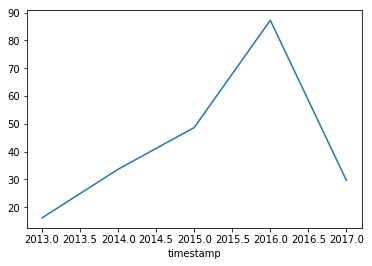

In [143]:
# Filter down:
sub = df.loc[df.kind == 'warcs'].loc[df.stream == 'domain']

# Show year-wise breakdown, as GB:
byy = sub.groupby(df.timestamp.dt.year).file_size.sum().apply(lambda x: x/(1000*1000*1000))

# And plot it:
byy.plot.line(x='timestamp',y='file_size')
